In [1]:
import zipfile

# Path to the zip file in Colab
zip_path = '/content/Segmented_SAR_Segment.zip'
extract_to = '/content/SAR_IMAGE_SEGMENT'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% for validation
)

# Path to the extracted dataset
dataset_path = '/content/SAR_IMAGE_SEGMENT'

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 6401 images belonging to 4 classes.
Found 1599 images belonging to 4 classes.


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load MobileNetV2 with pretrained weights, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers for SAR dataset classification
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(64, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras.optimizers import Adam

def compile_and_train(model, learning_rate, epochs):
    # Compile the model with the given learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1
    )

    # Return the final validation accuracy
    val_acc = history.history['val_accuracy'][-1]
    return val_acc


In [11]:
# Define hyperparameter grid
learning_rates = [1e-4]
epochs_list = [20]
results = {}

# Loop through each combination of hyperparameters
for lr in learning_rates:
    for epochs in epochs_list:
        print(f"Training with learning rate={lr} and epochs={epochs}")

        # Reinitialize the model for each grid search run
        temp_model = Model(inputs=base_model.input, outputs=output)

        # Train and evaluate the model
        val_acc = compile_and_train(temp_model, learning_rate=lr, epochs=epochs)

        # Store results
        results[(lr, epochs)] = val_acc
        print(f"Validation Accuracy with lr={lr}, epochs={epochs}: {val_acc}")


Training with learning rate=0.0001 and epochs=20
Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 107s 486ms/step - accuracy: 0.6134 - loss: 0.8736 - val_accuracy: 0.6223 - val_loss: 0.8567
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 133s 452ms/step - accuracy: 0.6651 - loss: 0.8064 - val_accuracy: 0.6285 - val_loss: 0.8680
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 441ms/step - accuracy: 0.6879 - loss: 0.7647 - val_accuracy: 0.6660 - val_loss: 0.7971
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 153s 489ms/step - accuracy: 0.6967 - loss: 0.7210 - val_accuracy: 0.6698 - val_loss: 0.7814
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 131s 441ms/step - accuracy: 0.7131 - loss: 0.7123 - val_accuracy: 0.6529 - val_loss: 0.8000
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 94s 455ms/step - accuracy: 0.7141 - loss: 0.6902 - val_accuracy: 0.6836 - val_loss: 0.7487
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 139s 436ms/step - accuracy: 0.7400 - loss: 0.6588 - val_accuracy: 0.7154 - val_loss: 0.6999
Epoch 8/20
201/201 ━━━━━━━━━━

In [12]:
# Find the best hyperparameters based on validation accuracy
best_params = max(results, key=results.get)
print(f"Best parameters: Learning Rate={best_params[0]}, Epochs={best_params[1]}")
print(f"Best Validation Accuracy: {results[best_params]:.4f}")


Best parameters: Learning Rate=0.0001, Epochs=20
Best Validation Accuracy: 0.7598


NameError: name 'history' is not defined

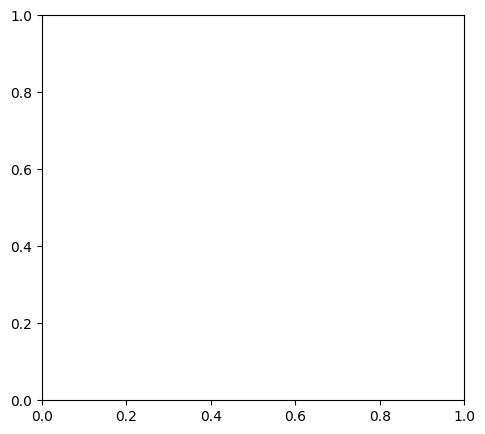

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 550ms/step


<Figure size 1000x800 with 0 Axes>

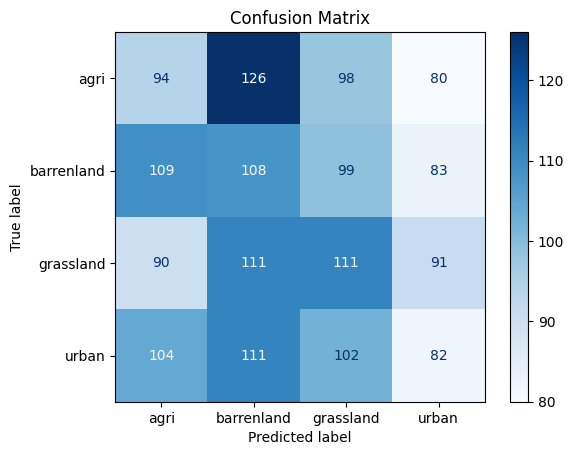

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Get true labels and predicted labels for the validation set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [21]:
from sklearn.metrics import classification_report

# Print the classification report
class_names = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        agri       0.24      0.24      0.24       398
  barrenland       0.24      0.27      0.25       399
   grassland       0.27      0.28      0.27       403
       urban       0.24      0.21      0.22       399

    accuracy                           0.25      1599
   macro avg       0.25      0.25      0.25      1599
weighted avg       0.25      0.25      0.25      1599



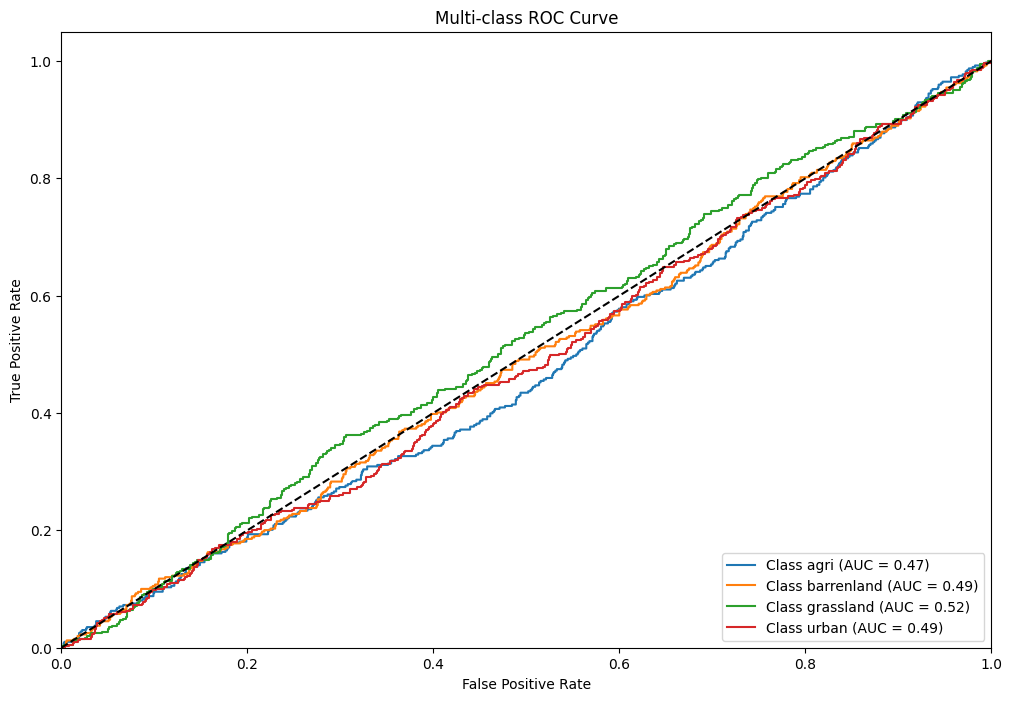

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools

# Binarize the output labels for multi-class ROC
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(n_classes))
y_pred_bin = Y_pred  # Already softmax probabilities

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

# Get a batch of images and labels from the validation generator
images, labels = next(validation_generator)  # This loads one batch from the generator
num_samples = 5  # Number of random images to display

# Randomly select 5 indices from the batch
random_indices = np.random.choice(len(images), num_samples, replace=False)
sample_images = images[random_indices]
sample_labels = labels[random_indices]


In [24]:
# Make predictions
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map class indices to class labels
class_labels = list(train_generator.class_indices.keys())
predicted_labels = [class_labels[i] for i in predicted_classes]
true_labels = [class_labels[np.argmax(label)] for label in sample_labels]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


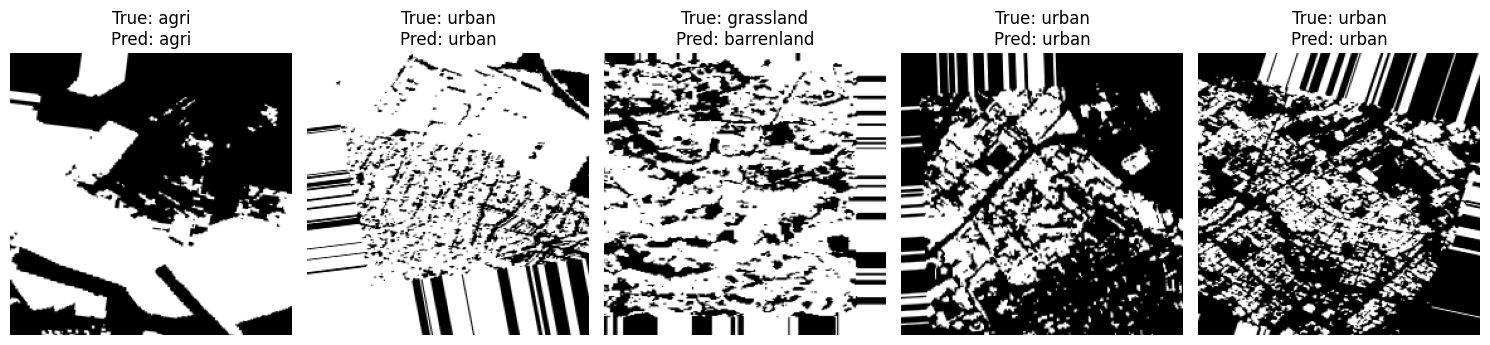

In [25]:
# Plot the images with actual and predicted labels
plt.figure(figsize=(15, 8))
for i, img in enumerate(sample_images):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(array_to_img(img))
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
